In [80]:
from src.time_series_prep import *
import pandas as pd
from models.shared_layer import *
from torchviz import make_dot
from torchsummary import summary
from src.data_preprocessing import *
from src.visualizations import *
from src.global_configs import *
from src.time_series_prep import *
import logging
from src.post_processing import *
from collections import defaultdict
from sklearn.metrics import r2_score
torch.set_printoptions(precision=10)  # Set precision to 10 decimal places

# Initialize logger
logging.basicConfig(
    filename='training.log',  # File where logs will be saved
    level=logging.INFO,  # Set logging level to INFO
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    # filemode='w'  # Overwrite log file on each run
)
logger = logging.getLogger()


In [81]:

scaler = process_all_csv_files(input_folder, output_folder_train, timestamp_col='ts', freq='5min', agg_func='mean')

In [174]:
model_type = 'shared-layer'
mask_scaled = 139.15895187396728
prediction_horizons = [3, 6, 9, 12, 15, 18]
abs_patients_errors_PHs =  {key: [] for key in prediction_horizons}
squared_patients_errors_PHs =  {key: [] for key in prediction_horizons}

In [5]:
train_loader, validation_loader, all_train_loader, test_loader, input_shape, input_shape_test, output_shape, output_shape_test =  prepare_data_loader(
                                                                                        window_size,BATCH_SIZE, 6,
                                                                                        model_type, split_ratio = 0.7, df = None, df_test = None, output_folder_train=output_folder_train, shuffle = False)

Shape of X (features): (12, 13612, 12)
Shape of y (targets): (12, 13612)
Shape of X_test (features): (12, 3933, 12)
Shape of y_test (targets): (12, 3933)


In [6]:
model_all_train_read =  SharedLayerModelWithAttention(input_shape =input_shape , output_shape=output_shape)
model_all_train_read.load_state_dict(torch.load(f'saved_models//model_{model_type}_attention_{str(6)}_{0}.pth',weights_only=False))
model_all_train_read.to(device)
model_all_train_read.eval();

In [205]:
outputs_all_batches, targets_all_batches = model_prediction(model_all_train_read,test_loader, device, model_type)
# predictions_flat = np.exp(scaler.inverse_transform(torch.cat(outputs_all_batches, dim=0).cpu()))
# ground_truth_flat = np.exp(scaler.inverse_transform(torch.cat(targets_all_batches, dim=0).cpu()))
# Convert tensors to CPU and concatenate batches
# Convert tensors to CPU and concatenate batches
# Convert tensors to CPU and concatenate batches
predictions_tensor = torch.cat(outputs_all_batches, dim=0).cpu()
ground_truth_tensor = torch.cat(targets_all_batches, dim=0).cpu()

# Mask zero values
predictions_mask = (predictions_tensor != 0)
ground_truth_mask = (ground_truth_tensor != 0)

# Initialize transformed tensors with zeros (to preserve zeros)
predictions_transformed = torch.zeros_like(predictions_tensor)
ground_truth_transformed = torch.zeros_like(ground_truth_tensor)

# Apply the scaler.inverse_transform only to non-zero values and convert back to torch tensor
if predictions_mask.any():
    non_zero_predictions = predictions_tensor[predictions_mask].unsqueeze(-1).numpy()
    inverse_transformed_predictions = scaler.inverse_transform(non_zero_predictions).squeeze()
    predictions_transformed[predictions_mask] = torch.exp(torch.tensor(
        inverse_transformed_predictions, dtype=predictions_tensor.dtype
    ))

if ground_truth_mask.any():
    non_zero_ground_truth = ground_truth_tensor[ground_truth_mask].unsqueeze(-1).numpy()
    inverse_transformed_ground_truth = scaler.inverse_transform(non_zero_ground_truth).squeeze()
    ground_truth_transformed[ground_truth_mask] = torch.exp(torch.tensor(
        inverse_transformed_ground_truth, dtype=ground_truth_tensor.dtype
    ))

ground_truth_flat = ground_truth_transformed
predictions_flat= predictions_transformed 

In [206]:
#R2 Score 

# Calculate R2 for each patient (each column)
r2_scores = []
for patient_idx in range(np.array(predictions_flat).shape[1]):  # Iterate over columns (patients)
    pred = predictions_flat[:, patient_idx]  # Get predictions for this patient
    true = ground_truth_flat[:, patient_idx]  # Get ground truth for this patient
    non_zero_mask = true != 0
    pred = pred[non_zero_mask]
    true = true[non_zero_mask]
    r2 = r2_score(true, pred)
    r2_scores.append(r2)
r2_scores


[0.9052676493265647,
 0.8325252140904036,
 0.9180502188847743,
 0.8470163131560583,
 0.8282279702485816,
 0.811296222467086,
 0.874703739073241,
 0.879338271057478,
 0.8708817487664965,
 0.8191915741983191,
 0.8542529400942458,
 0.8736133850785143]

In [ ]:
madp_scores = []
for patient_idx in range(predictions_flat.shape[1]):  # Iterate over columns (patients)
    pred = predictions_flat[:, patient_idx]  # Get predictions for this patient
    true = ground_truth_flat[:, patient_idx]  # Get ground truth for this patient
    
    # Avoid division by zero by excluding cases where true value is zero
    non_zero_mask = true != 0
    pred = pred[non_zero_mask]
    true = true[non_zero_mask]
    
    madp = (abs((true - pred) / true)).mean() * 100  # Calculate MADP
    madp_scores.append(madp)
# Step 3: Print MADP scores for each patient
for idx, madp in enumerate(madp_scores):
    print(f"Patient {idx+1} MADP: {madp:.2f}%")


Patient 1 MADP: 7.46%
Patient 2 MADP: 10.01%
Patient 3 MADP: 6.03%
Patient 4 MADP: 8.61%
Patient 5 MADP: 10.33%
Patient 6 MADP: 11.01%
Patient 7 MADP: 9.52%
Patient 8 MADP: 8.24%
Patient 9 MADP: 8.75%
Patient 10 MADP: 9.56%
Patient 11 MADP: 9.70%
Patient 12 MADP: 8.90%


In [243]:
np.mean(madp_scores)

9.010224

In [ ]:
import matplotlib.pyplot as plt
def calculate_zone_percentages(zones):
    total_points = sum(zones)
    if total_points == 0:
        return [0] * len(zones)  # Avoid division by zero if there are no points
    return [(count / total_points) * 100 for count in zones]

#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def clarke_error_grid(ref_values, pred_values, title_string, mask_value):
    if mask_value is not None:
        filtered_data = [(ref, pred) for ref, pred in zip(ref_values, pred_values) if ref != mask_value and pred != mask_value]

        ref_values, pred_values = zip(*filtered_data) if filtered_data else ([], [])
    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    # if max(ref_values) > 400 or max(pred_values) > 400:
    #     print "Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values))
    # if min(ref_values) < 0 or min(pred_values) < 0:
    #     print "Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='o', color='black', s=3)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B
    return plt, zone, calculate_zone_percentages(zone)

(<module 'matplotlib.pyplot' from 'd:\\NISC\\Glucose biomedical\\shared layer project\\biomedical-env\\Lib\\site-packages\\matplotlib\\pyplot.py'>,
 [29022, 2977, 0, 377, 0],
 [89.64047442550037, 9.19508277736595, 0.0, 1.1644427971336793, 0.0])

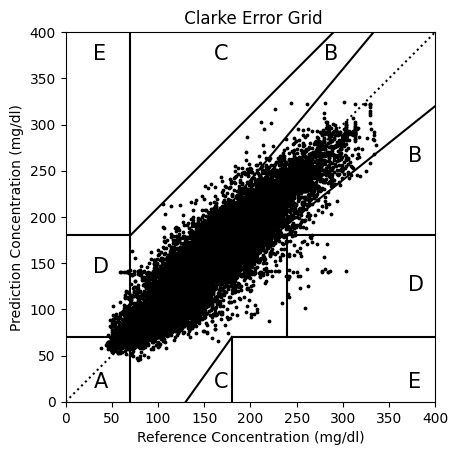

In [219]:
clarke_error_grid(ground_truth_flat.flatten(), predictions_flat.flatten(), "", mask_value)

In [ ]:
# how many hypo-hyper glycemia events are predicted wrong (missed) Zone D
# how many hypo-hyper glycemia covered ? No 
# how many normal event is perdicted in hyper-hypo?

In [ ]:
# import numpy as np
# from sklearn.metrics import matthews_corrcoef


# # Classify into binary categories
# def classify_glucose(values):
#     return np.where((values < 70) | (values > 180), 1, 0)
# # Filter out cases where target is 0
# valid_indices = ground_truth_flat.flatten() != 0  # Mask to exclude zeros in the target
# filtered_target = ground_truth_flat.flatten()[valid_indices]
# filtered_predicted = predictions_flat.flatten()[valid_indices]

# target_binary = classify_glucose(filtered_target)
# predicted_binary = classify_glucose(filtered_predicted)

# # Calculate counts
# true_positive = np.sum((target_binary == 1) & (predicted_binary == 1))  # Correctly predicted adverse events
# false_negative = np.sum((target_binary == 1) & (predicted_binary == 0))  # Missed adverse events
# false_positive = np.sum((target_binary == 0) & (predicted_binary == 1))  # Incorrectly predicted adverse events
# true_negative = np.sum((target_binary == 0) & (predicted_binary == 0))  # Correctly predicted euglycemic events

# # Total events
# total_adverse_events = np.sum(target_binary)  # Total adverse events (hyper/hypoglycemia)
# total_events = len(target_binary)  # Total valid events

# # Calculate percentages
# true_positive_percentage = (true_positive / total_adverse_events) * 100 if total_adverse_events > 0 else 0
# false_negative_percentage = (false_negative / total_adverse_events) * 100 if total_adverse_events > 0 else 0
# false_positive_percentage = (false_positive / total_events) * 100 if total_events > 0 else 0
# true_negative_percentage = (true_negative / total_events) * 100 if total_events > 0 else 0

# # Output results
# print("Total Hyper/Hypoglycemia Events in Target (Adverse Events):", total_adverse_events)
# print("True Positives (Covered Events):", true_positive, f"({true_positive_percentage:.2f}%)")
# print("False Negatives (Missed Events):", false_negative, f"({false_negative_percentage:.2f}%)")
# print("False Positives (Incorrectly Predicted Events):", false_positive, f"({false_positive_percentage:.2f}%)")
# print("True Negatives (Correctly Predicted Euglycemia):", true_negative, f"({true_negative_percentage:.2f}%)")

# # Calculate MCC
# mcc = matthews_corrcoef(target_binary, predicted_binary)
# print()
# print("Matthews Correlation Coefficient (MCC):", mcc)

Total Hyper/Hypoglycemia Events in Target (Adverse Events): 8500
True Positives (Covered Events): 6323 (74.39%)
False Negatives (Missed Events): 2177 (25.61%)
False Positives (Incorrectly Predicted Events): 1238 (3.82%)
True Negatives (Correctly Predicted Euglycemia): 22638 (69.92%)

Matthews Correlation Coefficient (MCC): 0.7197291869936003


In [ ]:
# # Classify hyperglycemia (glucose > 180) and hypoglycemia (glucose < 70) separately
# def classify_hyper(values):
#     return np.where(values > 180, 1, 0)  # 1 for hyperglycemia, 0 otherwise

# def classify_hypo(values):
#     return np.where(values < 70, 1, 0)  # 1 for hypoglycemia, 0 otherwise

# # Binary classifications for hyper and hypo events
# target_hyper = classify_hyper(filtered_target)
# predicted_hyper = classify_hyper(filtered_predicted)

# target_hypo = classify_hypo(filtered_target)
# predicted_hypo = classify_hypo(filtered_predicted)

# # Calculate metrics for hyperglycemia
# hyper_tp = np.sum((target_hyper == 1) & (predicted_hyper == 1))  # True Positives
# hyper_fn = np.sum((target_hyper == 1) & (predicted_hyper == 0))  # False Negatives
# hyper_fp = np.sum((target_hyper == 0) & (predicted_hyper == 1))  # False Positives
# hyper_tn = np.sum((target_hyper == 0) & (predicted_hyper == 0))  # True Negatives

# # Calculate metrics for hypoglycemia
# hypo_tp = np.sum((target_hypo == 1) & (predicted_hypo == 1))  # True Positives
# hypo_fn = np.sum((target_hypo == 1) & (predicted_hypo == 0))  # False Negatives
# hypo_fp = np.sum((target_hypo == 0) & (predicted_hypo == 1))  # False Positives
# hypo_tn = np.sum((target_hypo == 0) & (predicted_hypo == 0))  # True Negatives

# # Total hyper/hypoglycemia events
# total_hyper_events = np.sum(target_hyper)
# total_hypo_events = np.sum(target_hypo)
# total_events = len(filtered_target)

# # Calculate percentages for hyperglycemia
# hyper_tp_percentage = (hyper_tp / total_hyper_events) * 100 if total_hyper_events > 0 else 0
# hyper_fn_percentage = (hyper_fn / total_hyper_events) * 100 if total_hyper_events > 0 else 0
# hyper_fp_percentage = (hyper_fp / total_events) * 100 if total_events > 0 else 0
# hyper_tn_percentage = (hyper_tn / total_events) * 100 if total_events > 0 else 0

# # Calculate percentages for hypoglycemia
# hypo_tp_percentage = (hypo_tp / total_hypo_events) * 100 if total_hypo_events > 0 else 0
# hypo_fn_percentage = (hypo_fn / total_hypo_events) * 100 if total_hypo_events > 0 else 0
# hypo_fp_percentage = (hypo_fp / total_events) * 100 if total_events > 0 else 0
# hypo_tn_percentage = (hypo_tn / total_events) * 100 if total_events > 0 else 0

# # Output results
# print("Hyperglycemia Metrics:")
# print("  Total Hyperglycemia Events in Target:", total_hyper_events)
# print("  True Positives (Covered Events):", hyper_tp, f"({hyper_tp_percentage:.2f}%)")
# print("  False Negatives (Missed Events):", hyper_fn, f"({hyper_fn_percentage:.2f}%)")
# print("  False Positives (Incorrectly Predicted Events):", hyper_fp, f"({hyper_fp_percentage:.2f}%)")
# print("  True Negatives (Correctly Predicted Non-Hyperglycemia):", hyper_tn, f"({hyper_tn_percentage:.2f}%)")

# print("\nHypoglycemia Metrics:")
# print("  Total Hypoglycemia Events in Target:", total_hypo_events)
# print("  True Positives (Covered Events):", hypo_tp, f"({hypo_tp_percentage:.2f}%)")
# print("  False Negatives (Missed Events):", hypo_fn, f"({hypo_fn_percentage:.2f}%)")
# print("  False Positives (Incorrectly Predicted Events):", hypo_fp, f"({hypo_fp_percentage:.2f}%)")
# print("  True Negatives (Correctly Predicted Non-Hypoglycemia):", hypo_tn, f"({hypo_tn_percentage:.2f}%)")

Hyperglycemia Metrics:
  Total Hyperglycemia Events in Target: 7519
  True Positives (Covered Events): 5975 (79.47%)
  False Negatives (Missed Events): 1544 (20.53%)
  False Positives (Incorrectly Predicted Events): 1040 (3.21%)
  True Negatives (Correctly Predicted Non-Hyperglycemia): 23817 (73.56%)

Hypoglycemia Metrics:
  Total Hypoglycemia Events in Target: 981
  True Positives (Covered Events): 348 (35.47%)
  False Negatives (Missed Events): 633 (64.53%)
  False Positives (Incorrectly Predicted Events): 198 (0.61%)
  True Negatives (Correctly Predicted Non-Hypoglycemia): 31197 (96.36%)


In [ ]:

# # Classify hyperglycemia (glucose > 180) and hypoglycemia (glucose < 70) separately
# def classify_hyper(values):
#     return np.where(values > 180, 1, 0)  # 1 for hyperglycemia, 0 otherwise

# def classify_hypo(values):
#     return np.where(values < 70, 1, 0)  # 1 for hypoglycemia, 0 otherwise

# # Binary classifications for hyper and hypo events
# target_hyper = classify_hyper(filtered_target)
# predicted_hyper = classify_hyper(filtered_predicted)

# target_hypo = classify_hypo(filtered_target)
# predicted_hypo = classify_hypo(filtered_predicted)

# # Calculate metrics for hyperglycemia
# hyper_tp = np.sum((target_hyper == 1) & (predicted_hyper == 1))  # True Positives
# hyper_fn = np.sum((target_hyper == 1) & (predicted_hyper == 0))  # False Negatives
# hyper_fp = np.sum((target_hyper == 0) & (predicted_hyper == 1))  # False Positives
# hyper_tn = np.sum((target_hyper == 0) & (predicted_hyper == 0))  # True Negatives

# # Calculate metrics for hypoglycemia
# hypo_tp = np.sum((target_hypo == 1) & (predicted_hypo == 1))  # True Positives
# hypo_fn = np.sum((target_hypo == 1) & (predicted_hypo == 0))  # False Negatives
# hypo_fp = np.sum((target_hypo == 0) & (predicted_hypo == 1))  # False Positives
# hypo_tn = np.sum((target_hypo == 0) & (predicted_hypo == 0))  # True Negatives

# # Manual MCC calculation for hyperglycemia
# hyper_mcc_numerator = (hyper_tp * hyper_tn) - (hyper_fp * hyper_fn)
# hyper_mcc_denominator = np.sqrt(
#     (hyper_tp + hyper_fp) * (hyper_tp + hyper_fn) * (hyper_tn + hyper_fp) * (hyper_tn + hyper_fn)
# )
# hyper_mcc = hyper_mcc_numerator / hyper_mcc_denominator if hyper_mcc_denominator > 0 else 0

# # Manual MCC calculation for hypoglycemia
# hypo_mcc_numerator = (hypo_tp * hypo_tn) - (hypo_fp * hypo_fn)
# hypo_mcc_denominator = np.sqrt(
#     (hypo_tp + hypo_fp) * (hypo_tp + hypo_fn) * (hypo_tn + hypo_fp) * (hypo_tn + hypo_fn)
# )
# hypo_mcc = hypo_mcc_numerator / hypo_mcc_denominator if hypo_mcc_denominator > 0 else 0

# # Calculate MCC using sklearn for comparison
# hyper_mcc_sklearn = matthews_corrcoef(target_hyper, predicted_hyper)
# hypo_mcc_sklearn = matthews_corrcoef(target_hypo, predicted_hypo)

# # Output results
# print("Hyperglycemia MCC (Manual):", hyper_mcc)
# print("Hyperglycemia MCC (sklearn):", hyper_mcc_sklearn)

# print("Hypoglycemia MCC (Manual):", hypo_mcc)
# print("Hypoglycemia MCC (sklearn):", hypo_mcc_sklearn)

Hyperglycemia MCC (Manual): 3044.3550143950406
Hyperglycemia MCC (sklearn): 0.7716052781887126
Hypoglycemia MCC (Manual): 361.95416857453404
Hypoglycemia MCC (sklearn): 0.4638417016761874


C:\Users\menna\AppData\Local\Temp\ipykernel_33452\2744117051.py:30: RuntimeWarning: overflow encountered in scalar multiply
  (hyper_tp + hyper_fp) * (hyper_tp + hyper_fn) * (hyper_tn + hyper_fp) * (hyper_tn + hyper_fn)
C:\Users\menna\AppData\Local\Temp\ipykernel_33452\2744117051.py:37: RuntimeWarning: overflow encountered in scalar multiply
  (hypo_tp + hypo_fp) * (hypo_tp + hypo_fn) * (hypo_tn + hypo_fp) * (hypo_tn + hypo_fn)


In [233]:
# # Define adverse events consistently for both functions
# def detect_events(values, hypo_threshold=70, hyper_threshold=180):
#     """Detect adverse and euglycemia events."""
#     adverse_events = (values < hypo_threshold) | (values > hyper_threshold)
#     euglycemia_events = ~adverse_events
#     return adverse_events, euglycemia_events
# def calculate_coverage_and_false_alarms(predictions, ground_truth, hypo_threshold=70, hyper_threshold=180, mask_value=0):
#     """
#     Calculate hypoglycemia and hyperglycemia coverage and false alarms for each patient,
#     with robust handling of event detection and proper exclusion of masked values.
#     """
#     hypo_coverage = []
#     hyper_coverage = []
#     hypo_false_alarm = []
#     hyper_false_alarm = []

#     total_hypo_correct = 0
#     total_hypo_events = 0
#     total_hyper_correct = 0
#     total_hyper_events = 0

#     for patient_idx in range(predictions.shape[1]):  # Iterate over each patient
#         pred = predictions[:, patient_idx]
#         true = ground_truth[:, patient_idx]

#         # Exclude masked values
#         valid_indices = (true != mask_value)
#         pred = pred[valid_indices]
#         true = true[valid_indices]

#         # Detect hypoglycemia and hyperglycemia events
#         true_hypo_events = (true < hypo_threshold)
#         pred_hypo_events = (pred < hypo_threshold)

#         true_hyper_events = (true > hyper_threshold)
#         pred_hyper_events = (pred > hyper_threshold)

#         # Hypoglycemia coverage
#         correct_hypo_predictions = (pred_hypo_events & true_hypo_events).sum()
#         hypo_event_count = true_hypo_events.sum()
#         total_hypo_correct += correct_hypo_predictions
#         total_hypo_events += hypo_event_count

#         if hypo_event_count > 0:
#             hypo_coverage.append(correct_hypo_predictions / hypo_event_count * 100)
#         else:
#             hypo_coverage.append(None)  # No hypoglycemia events for this patient

#         # Hyperglycemia coverage
#         correct_hyper_predictions = (pred_hyper_events & true_hyper_events).sum()
#         hyper_event_count = true_hyper_events.sum()
#         total_hyper_correct += correct_hyper_predictions
#         total_hyper_events += hyper_event_count

#         if hyper_event_count > 0:
#             hyper_coverage.append(correct_hyper_predictions / hyper_event_count * 100)
#         else:
#             hyper_coverage.append(None)  # No hyperglycemia events for this patient

#         # False alarms
#         hypo_false_alarms = (pred_hypo_events & ~true_hypo_events).sum() / len(true) * 100
#         hyper_false_alarms = (pred_hyper_events & ~true_hyper_events).sum() / len(true) * 100

#         hypo_false_alarm.append(hypo_false_alarms)
#         hyper_false_alarm.append(hyper_false_alarms)

#     # Overall metrics
#     overall_hypo_coverage = (total_hypo_correct / total_hypo_events * 100) if total_hypo_events > 0 else None
#     overall_hyper_coverage = (total_hyper_correct / total_hyper_events * 100) if total_hyper_events > 0 else None

#     overall_hypo_false_alarm = np.mean(hypo_false_alarm)
#     overall_hyper_false_alarm = np.mean(hyper_false_alarm)

#     return {
#         "hypo_coverage": hypo_coverage,
#         "hyper_coverage": hyper_coverage,
#         "overall_hypo_coverage": overall_hypo_coverage,
#         "overall_hyper_coverage": overall_hyper_coverage,
#         "overall_hypo_false_alarm": overall_hypo_false_alarm,
#         "overall_hyper_false_alarm": overall_hyper_false_alarm,
#     }



# def calculate_mcc(predictions, ground_truth, hypo_threshold=70, hyper_threshold=180, mask_value=0):
#     """
#     Calculate Matthews Correlation Coefficient (MCC) with detailed debugging outputs.
#     """
#     valid_indices = (ground_truth != mask_value) & (predictions != mask_value)
#     pred = predictions[valid_indices]
#     true = ground_truth[valid_indices]

#     # Detect events consistently
#     true_adverse, true_euglycemia = detect_events(true, hypo_threshold, hyper_threshold)
#     pred_adverse, pred_euglycemia = detect_events(pred, hypo_threshold, hyper_threshold)
#     print(true_adverse)
#     print(pred_adverse)
#     # Calculate TP, TN, FP, FN
#     TP = np.sum(true_adverse & pred_adverse).astype(np.float64)
#     TN = np.sum(true_euglycemia & pred_euglycemia).astype(np.float64)
#     FP = np.sum(true_euglycemia & pred_adverse).astype(np.float64)
#     FN = np.sum(true_adverse & pred_euglycemia).astype(np.float64)

#     print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

#     numerator = (TP * TN) - (FP * FN)
#     denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

#     mcc = numerator / denominator if denominator > 0 else 0
#     return mcc, {"TP": TP, "TN": TN, "FP": FP, "FN": FN}




In [234]:
# # Calculate MCC
# mcc, confusion_matrix = calculate_mcc(predictions_flat, ground_truth_flat)

# # Print Results
# print("Matthews Correlation Coefficient (MCC):", mcc)
# print("Confusion Matrix:", confusion_matrix)

In [235]:
# dict_overall = calculate_coverage_and_false_alarms(predictions_flat, ground_truth_flat)
# dict_overall

In [236]:
# def detect_event_classification(values, hypo_threshold=70, hyper_threshold=180):
#     """
#     Classify glucose values into hypoglycemia, hyperglycemia, or euglycemia.
#     """
#     adverse_event = (values < hypo_threshold) | (values > hyper_threshold)  # Adverse events
#     hypo_event = values < hypo_threshold  # Hypoglycemia
#     hyper_event = values > hyper_threshold  # Hyperglycemia
#     euglycemia_event = ~adverse_event  # Complement: Euglycemia
#     return hypo_event, hyper_event, euglycemia_event

# print(f"Patient {patient_idx + 1}:")
# print(f"  Total Hypoglycemia Events: {hypo_event_count}")
# print(f"  Correct Hypoglycemia Predictions: {correct_hypo_predictions}")
# print(f"  Total Hyperglycemia Events: {hyper_event_count}")
# print(f"  Correct Hyperglycemia Predictions: {correct_hyper_predictions}")
